In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()
import handwriting_split_data as data_load

IMAGE_PATH = os.path.join(ROOT_DIR, "data/hand/images")
MASK_PATH = os.path.join(ROOT_DIR, "data/hand/masks")

images = data_load.label_images(n_splits=5)
index_train_cv = np.where(images != 0)
index_valid_cv = np.where(images == 0 )
files = data_load._img_json_files()

X_train_cv = np.array([x for x in files if files.index(x) in index_train_cv[0]])
X_valid = np.array([x for x in files if files.index(x) in index_valid_cv[0]])

print(X_train_cv.shape)
print(X_valid.shape)

print(X_train_cv[0])

extract_features
load feature
Loaded VGG16 features:  (70, 512)
sort images
[0 1 2 3 4]
(56,)
(14,)
data/handwriting/000_056_crop.jpg


In [63]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
def load_mask(json_name, json_base_path='', height=64, width=128):
    # print(json_name)
    instance_masks = []
    class_ids = []

    img = np.zeros([height, width], dtype=np.uint8)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    df = pd.read_json(os.path.join(json_base_path, json_name), typ='series')

    # print(df)
    for idx, shape in enumerate(df.shapes):
        class_id = shape['label']
        box = shape['points']
        m = utils.draw_polygon(img.copy(), box, 1)
        resized = cv2.resize(m, (128, 64))
        instance_masks.append(resized)
        class_ids.append(class_id)

    if class_ids:
        masks = np.stack(instance_masks, axis=0)
        class_ids = np.array(class_ids, dtype=np.int32)
#         print("masks", masks.shape)
#         print("class_ids", class_ids.shape)
        return masks, class_ids

In [59]:
def resize_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, (128, 64))
    # resized = cv2.resize(img, (144 * 2, 256 * 2))
    return resized, img.shape


In [81]:
N = 5
width = 64
height = 128
channels = 3

def dataset_gen(X_train_cv):
    length = X_train_cv.shape[0]
    images = np.ndarray([length,width,height,channels], dtype='float32')
    masks  = np.ndarray([length,N,width,height], dtype='float32')
    labels = np.ones([length, N], dtype=int) * 10 # init to 10 cause it would be no digit

    # import shutil
    for idx, p in enumerate(X_train_cv):
    #     print(p)
        img, img_shape = resize_img(p)
    #     print("img_shape", img_shape)
        images[idx] = img
    #     images.append(img)
        base_name = os.path.splitext(os.path.basename(p))[0]
        json_name = "%s.json" % base_name
        msks, class_ids = load_mask(json_name, json_base_path='data/handwriting/', height=img_shape[0], width=img_shape[1])
    #     print("msks", msks.shape)
        for i in range(msks.shape[0]):
            masks[idx, i] = msks[i]

        for i in range(class_ids.shape[0]):
            labels[idx, i] = class_ids[i]
    #     masks.append(ms)
    #     labels.append(class_ids)
    return images, masks, labels

In [82]:
images, masks, labels = dataset_gen(X_train_cv)

print(np.array(images).shape)
print(np.array(masks).shape)
print(np.array(labels).shape)
print(labels[1])

(56, 64, 128, 3)
(56, 5, 64, 128)
(56, 5)
[ 1  8 10 10 10]


In [84]:
images1, masks1, labels1 = dataset_gen(X_valid)

print(np.array(images1).shape)
print(np.array(masks1).shape)
print(np.array(labels1).shape)
print(labels1[1])

(14, 64, 128, 3)
(14, 5, 64, 128)
(14, 5)
[ 7 10 10 10 10]


sample (64, 128, 3)


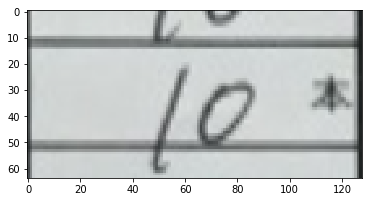

(5, 64, 128)


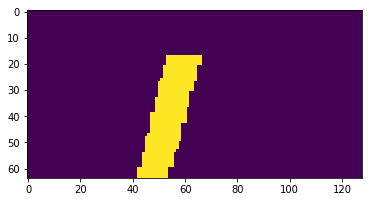

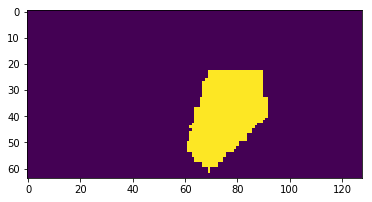

[ 1  0 10 10 10]


In [86]:
rd = 9
sample = images1[rd,:,:,:].copy()
print("sample", sample.shape)
# print(np.unique(sample))
# sample = sample.reshape(sample.shape[0], sample.shape[1], 3).astype(np.float32)
sample /= 255
plt.imshow(sample)
plt.show()

print(masks1[rd].shape)
plt.imshow(masks1[rd][0])
plt.show()
plt.imshow(masks1[rd][1])
plt.show()
print(labels1[rd])